In [1]:
pip install catboost

  Obtaining dependency information for catboost from https://files.pythonhosted.org/packages/03/9f/5da788602cb9a2ce70abd9b3f9650dc53e6ec834e746b8dd053cb4314ca3/catboost-1.2.5-cp311-cp311-macosx_11_0_universal2.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 11.2 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
from catboost import CatBoostRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split

# Importar funcions per evaluar els models
from utils import evaluate_models
from utils import plot_model_evaluation

ImportError: cannot import name 'CatboostRegressor' from 'catboost' (/Users/albam/Applications/anaconda3/lib/python3.11/site-packages/catboost/__init__.py)

In [4]:
pth2= "../Gorrapiedra-proyecto/data/formated data/"
info_station2= "../Gorrapiedra-proyecto/data/info bicing/Informacio_Estacions_Bicing.csv"


df_20 = pd.read_csv(os.path.join(pth2, "data_2020.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_21 = pd.read_csv(os.path.join(pth2, "data_2021.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_22 = pd.read_csv(os.path.join(pth2, "data_2022.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_23 = pd.read_csv(os.path.join(pth2, "data_2023.csv"), index_col=False, skipinitialspace=True, skip_blank_lines=True)
df_info = pd.read_csv(os.path.join(info_station2), index_col=False, skipinitialspace=True, skip_blank_lines=True)

dfs_list = [df_20, df_21, df_22, df_23, df_info]

# Eliminem les estacions que no estan a tots els datasets

for proto_df in dfs_list:       # fyi: en aquest cas, totes les estacions estan a tots els datasets
    for otro_df in dfs_list:
        if proto_df is not otro_df:
            proto_df = proto_df[proto_df['station_id'].isin(otro_df['station_id'])]

df_info_stations = df_info[['station_id', 'lat', 'lon', 'post_code', 'capacity']]

df = pd.concat([df_20, df_21, df_22, df_23], ignore_index = True)
df = pd.merge(df, df_info_stations, on='station_id')

if 'Unnamed: 0' in df.columns:
    df = df.drop(['Unnamed: 0'], axis=1)   # Eliminar columna Unnamed

# Visualitzar el df
df.head()

,station_id,year,month,day,hour,ctx-4,ctx-3,ctx-2,ctx-1,percentage_docks_available,lat,lon,post_code,capacity
0,1.0,2020.0,1.0,1.0,2.0,0.522727,0.503788,0.469697,0.403409,0.354167,41.397978,2.180107,8013,45
1,1.0,2020.0,1.0,1.0,7.0,0.289773,0.373106,0.304924,0.238636,0.240530,41.397978,2.180107,8013,45
2,1.0,2020.0,1.0,1.0,12.0,0.253788,0.268939,0.350379,0.344697,0.393939,41.397978,2.180107,8013,45
3,1.0,2020.0,1.0,1.0,17.0,0.390152,0.346591,0.255814,0.220930,0.186047,41.397978,2.180107,8013,45
4,1.0,2020.0,1.0,1.0,22.0,0.083333,0.218992,0.437984,0.515504,0.470930,41.397978,2.180107,8013,45


In [5]:
# Separar les característiques (X) de la variable objectiu (y)
X = df.drop(['percentage_docks_available'], axis=1)
y = df['percentage_docks_available']

In [6]:
# Dividim les dades en conjunts de training i testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Crear el model

model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, loss_function='RMSE', verbose=200)
model.fit(X_train, y_train)

0:	learn: 0.2622747	total: 157ms	remaining: 2m 37s
200:	learn: 0.1083984	total: 37.3s	remaining: 2m 28s
400:	learn: 0.1070293	total: 1m 11s	remaining: 1m 46s
600:	learn: 0.1062795	total: 1m 38s	remaining: 1m 5s
800:	learn: 0.1057642	total: 2m 16s	remaining: 33.8s
999:	learn: 0.1053692	total: 2m 43s	remaining: 0us


In [13]:
# Fem les prediccions
y_pred_catboost = model.predict(X_test)

In [14]:
# Evaluar el model
results = evaluate_models(y_test, y_pred_catboost)

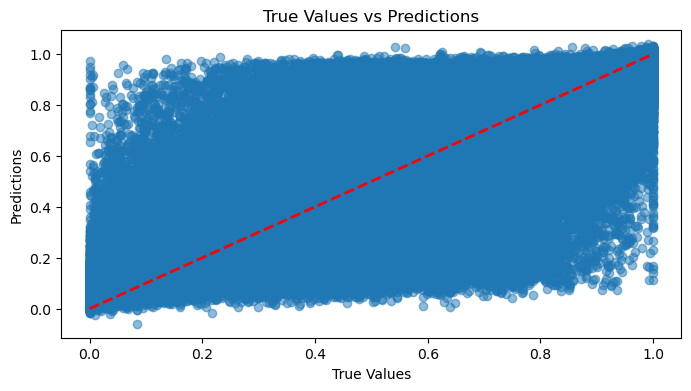

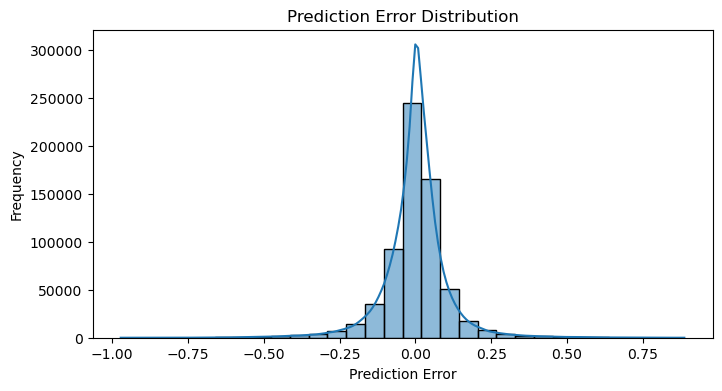

In [15]:
# Visualitzar l'evaluació del model
plot_model_evaluation(y_test, y_pred_catboost)

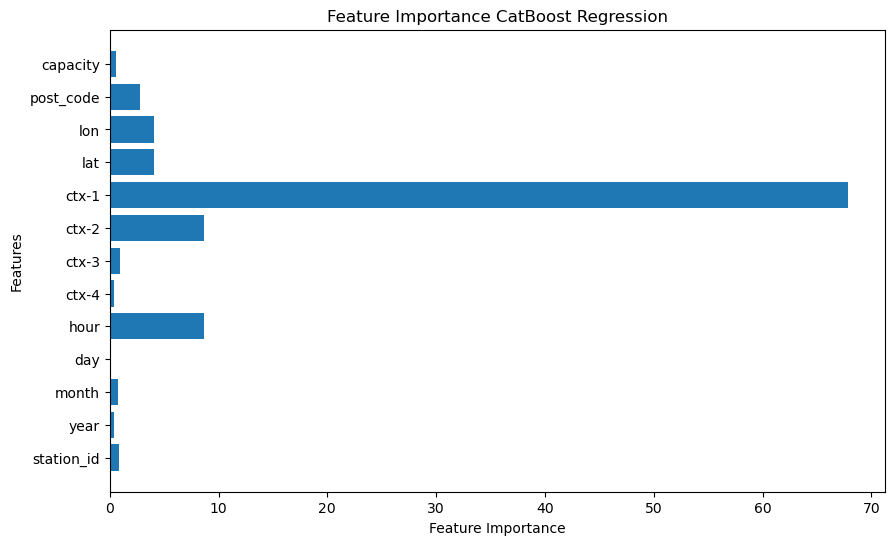

In [17]:
# Feature importance 
plt.figure(figsize=(10, 6))
plt.barh(X.columns, model.feature_importances_)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance CatBoost Regression')
plt.show()